## SHAP Feature Importance Aggregation Across Models

This notebook analyzes and visualizes feature importance across different models using aggregated SHAP values.

### 1. Input Data
- CSV file with repeated column pairs: `[Feature, SHAP value]` per model.

### 2. Data Transformation
- `reshape_shap_csv()`: reshapes data to long format with columns:
  - `Model`, `Feature`, `SHAP`, `Rank` (1 = most important).
- `reshape_shap_csv_reversed()`: assigns reversed ranks for visualization contrast.

### 3. Mean Ranking
- `compute_mean_ranks()`: computes per-feature mean and std of:
  - SHAP values
  - Feature ranks
- Output is sorted by mean rank (descending importance).

### 4. Visualizations
- `plot_rank_heatmap()`: rank heatmap across models.
- `plot_shap_mean_std_barplot()`: mean ± std of SHAP values per feature.
- `plot_feature_rank_barplot()`: mean ± std of feature ranks across models.

### Goal
Identify features that are consistently important across ML architectures.


In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/Users/I566184/bachelorarbeit_coding/mesogeos/csv/Shap_Importance_across_Models.csv", sep=";")
def reshape_shap_csv(df: pd.DataFrame):
    records = []
    for i in range(0, df.shape[1], 2):
        model_name = df.columns[i]
        shap_column = df.columns[i+1]
        features = df[model_name]
        shap_values = df[shap_column]

        #max_rank = len(features)
        for rank, (feature, shap_value) in enumerate(zip(features, shap_values), 1):
            #reversed_rank = max_rank - rank + 1
            records.append({
                "Model": model_name,
                "Feature": feature,
                "SHAP": shap_value,
                "Rank": rank
            })

    return pd.DataFrame(records)
df_ordered = reshape_shap_csv(df)

def reshape_shap_csv_reveresed(df: pd.DataFrame):
    records = []
    for i in range(0, df.shape[1], 2):
        model_name = df.columns[i]
        shap_column = df.columns[i+1]
        features = df[model_name]
        shap_values = df[shap_column]

        max_rank = len(features)
        for rank, (feature, shap_value) in enumerate(zip(features, shap_values), 1):
            reversed_rank = max_rank - rank + 1
            records.append({
                "Model": model_name,
                "Feature": feature,
                "SHAP": shap_value,
                "Rank": reversed_rank
            })

    return pd.DataFrame(records)
df_ordered = reshape_shap_csv(df)
df_reversed = reshape_shap_csv_reveresed(df)

In [3]:
def compute_mean_ranks1(df: pd.DataFrame, output_path: str = "mean_ranks.csv"):
    mean_ranks = df.groupby('Feature')['Rank'].agg(['mean', 'std']).reset_index()
    mean_ranks.columns = ['Feature', 'MeanRank', 'StdRank']
    mean_ranks.sort_values("MeanRank", inplace=True)
    mean_ranks.to_csv(output_path, index=False)
    return mean_ranks

def compute_mean_ranks(df: pd.DataFrame, output_path: str = "mean_ranks.csv"):
    grouped = df.groupby('Feature').agg(
        MeanRank=('Rank', 'mean'),
        StdRank=('Rank', 'std'),
        MeanSHAP=('SHAP', 'mean'),
        StdSHAP=('SHAP', 'std')
    ).reset_index()

    grouped.sort_values("MeanRank", ascending=False, inplace=True)
    grouped.to_csv(output_path, index=False)
    return grouped

def plot_shap_heatmap(df: pd.DataFrame):
    pivot = df.pivot(index='Model', columns='Feature', values='SHAP')
    plt.figure(figsize=(15, 6))
    sns.heatmap(pivot, annot=False, cmap="RdBu_r", cbar_kws={'label': 'Aggregated SHAP'})
    plt.title("Aggregated SHAP Values across Models", rotation=0, fontsize=14, fontweight='medium')
    plt.tight_layout()
    plt.show()

def plot_rank_heatmap(df: pd.DataFrame):
    pivot = df.pivot(index='Model', columns='Feature', values='Rank')

    fig, ax = plt.subplots(figsize=(15, 6))
    sns.heatmap(pivot, annot=False, cmap="RdBu_r", cbar=False, ax=ax)

    norm = plt.Normalize(vmin=pivot.min().min(), vmax=pivot.max().max())
    sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
    sm.set_array([])
    
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical", pad=0.02)
    cbar.set_ticks([pivot.min().min(), pivot.max().max()])
    cbar.set_ticklabels(["Low\nImportance", "High\nImportance"])
    cbar.ax.tick_params(labelsize=16)
    

    ax.set_title("Feature Ranks across Models", fontsize=16, fontweight='medium')
    ax.set_ylabel("Models", fontsize=16, fontweight='medium')
    ax.set_xlabel("Features", fontsize=16, fontweight='medium')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=14, fontweight='medium')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right", fontsize=14, fontweight='medium')

    plt.tight_layout()
    plt.show()


In [4]:
compute_mean_ranks(df_ordered, output_path="/Users/I566184/bachelorarbeit_coding/mesogeos/csv/mean_ranks.csv")

,Feature,MeanRank,StdRank,MeanSHAP,StdSHAP
9,lc_water_bodies,23.500,0.925820,20.302502,24.157203
6,lc_settlement,22.625,0.916125,44.335659,17.543927
10,lc_wetland,22.000,1.511858,34.385885,24.252138
8,lc_sparse_vegetation,20.375,1.302470,49.337076,16.758143
14,population,20.000,3.741657,55.691070,6.764080
16,roads_distance,17.500,1.772811,59.235658,18.843830
5,lc_grassland,17.375,1.846812,58.979176,12.795440
4,lc_forest,16.125,2.850439,67.418281,16.066825
2,lai,16.000,1.603567,64.026397,12.208162
3,lc_agriculture,14.625,4.274091,79.385358,39.383708


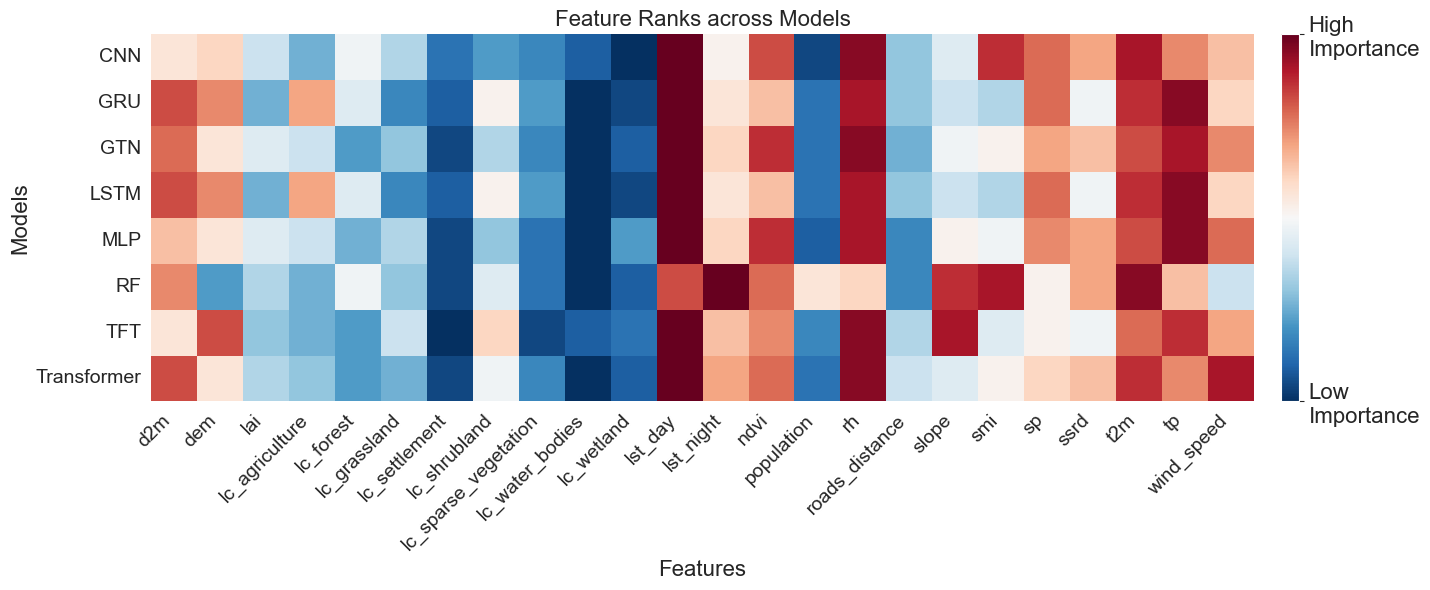

In [5]:
plot_rank_heatmap(df_reversed)

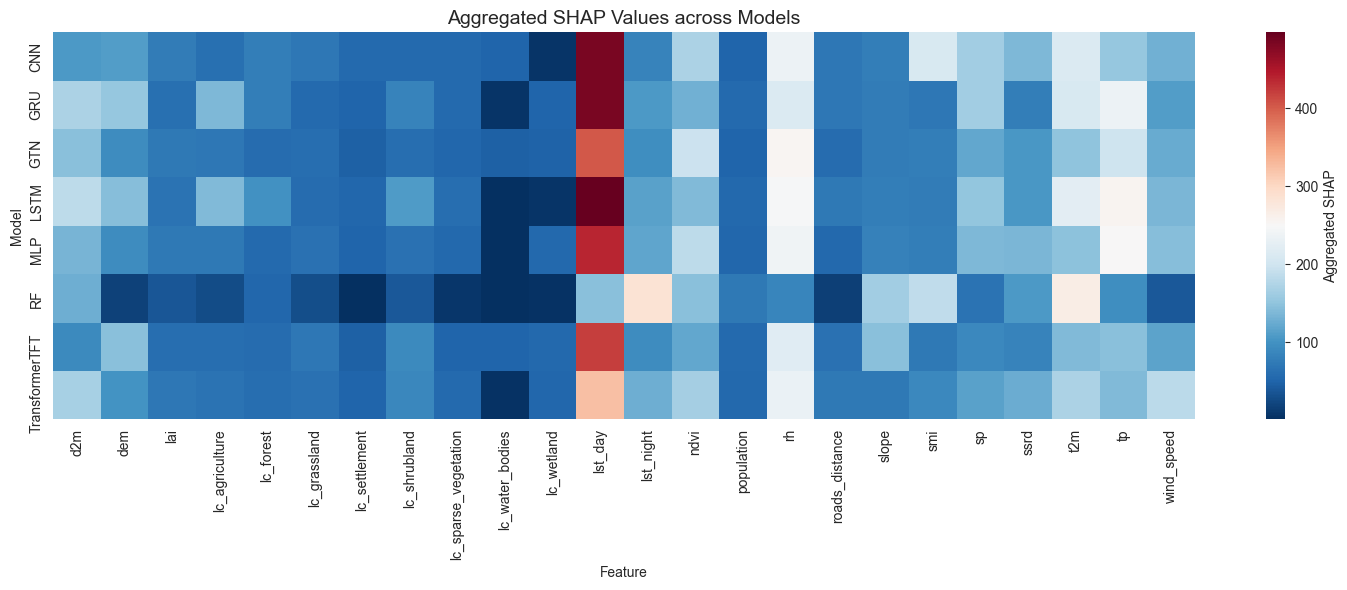

In [6]:
#nicht verwenden, da nicht aussagekräftig
plot_shap_heatmap(df_ordered)

In [42]:
def plot_shap_mean_std_barplot(df_ordered: pd.DataFrame):
    summary = df_ordered.groupby("Feature")["SHAP"].agg(["mean", "std"]).reset_index()
    summary = summary.sort_values("mean", ascending=False)


    vmax = summary["mean"].max()
    vmin = summary["mean"].min()
    vcenter = summary["mean"].quantile(0.5)  

    norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    color_values = [cm.RdBu_r(norm(val)) for val in summary["mean"]]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(
        summary["Feature"],
        summary["mean"],
        yerr=summary["std"],
        capsize=5,
        color=color_values,
    )

    plt.ylabel("Mean |SHAP| Value", fontsize=14, fontweight='medium')
    plt.xticks(rotation=45, ha="right", fontsize=12, fontweight='medium')
    plt.yticks(fontsize=14)
    plt.title("Average Absolute SHAP Values per Feature Across All Models", fontsize=14, fontweight='medium')
    plt.tight_layout()
    plt.show()


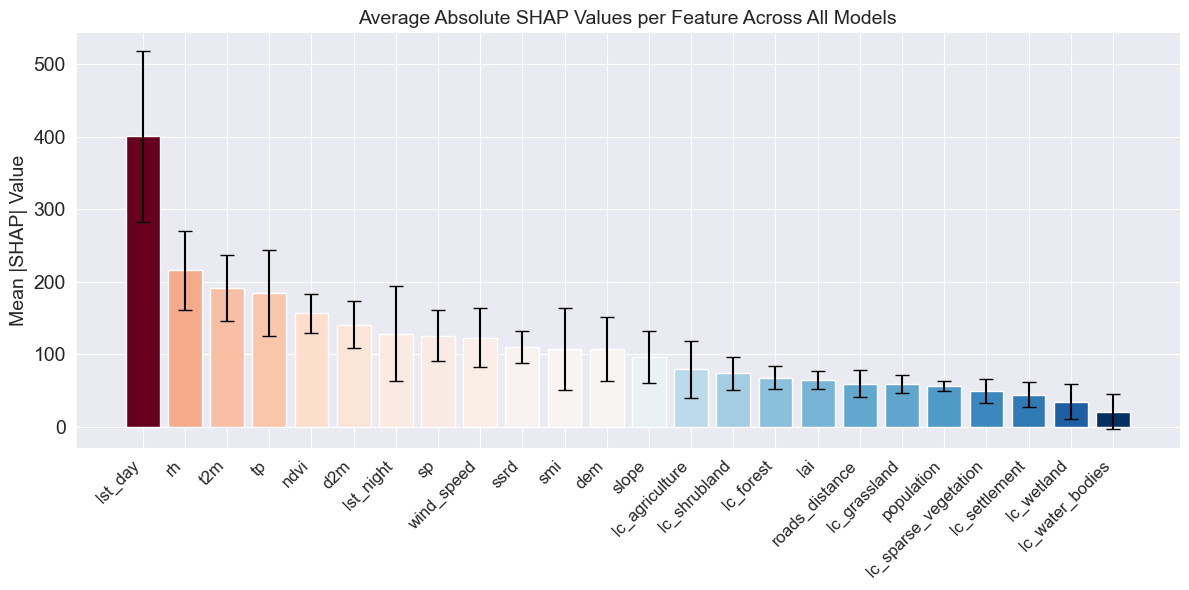

In [43]:
plot_shap_mean_std_barplot(df_ordered)

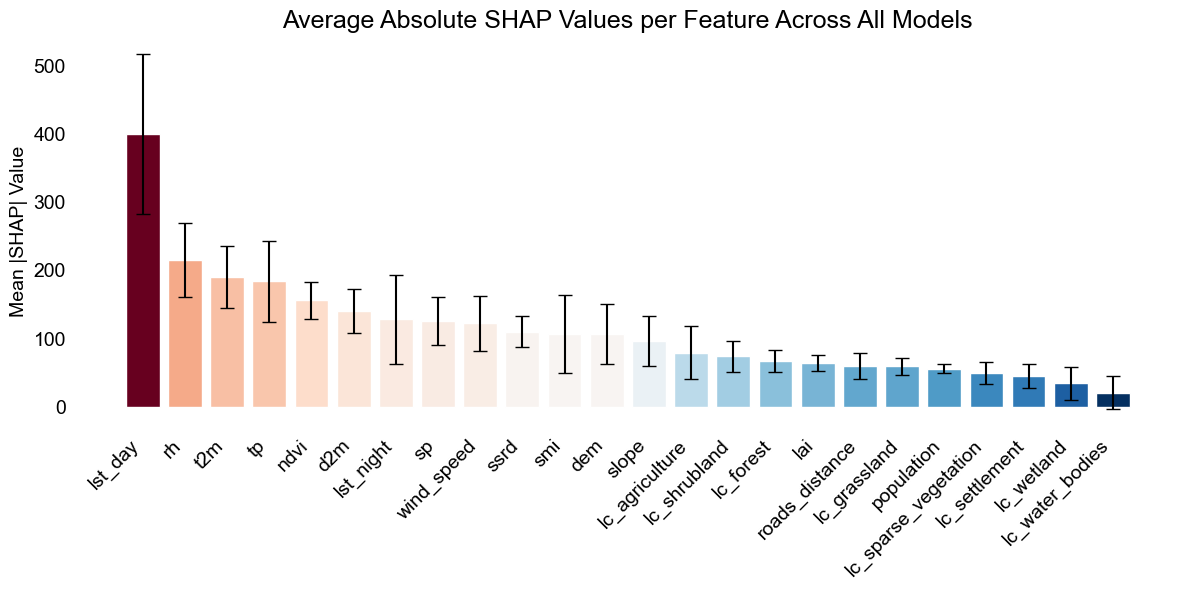

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import pandas as pd

def plot_shap_mean_std_barplot_transparent(df_ordered: pd.DataFrame):
    summary = df_ordered.groupby("Feature")["SHAP"].agg(["mean", "std"]).reset_index()
    summary = summary.sort_values("mean", ascending=False)

    vmax = summary["mean"].max()
    vmin = summary["mean"].min()
    vcenter = summary["mean"].quantile(0.5)

    norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    color_values = [cm.RdBu_r(norm(val)) for val in summary["mean"]]

    fig, ax = plt.subplots(figsize=(12, 6))

    bars = ax.bar(
        summary["Feature"],
        summary["mean"],
        yerr=summary["std"],
        capsize=5,
        color=color_values,
    )

    # Achsenbeschriftung schwarz setzen
    ax.set_ylabel("Mean |SHAP| Value", fontsize=14, fontweight='medium', color='black')
    ax.set_xlabel("")  # kein Label für x-Achse notwendig
    ax.set_xticks(range(len(summary["Feature"])))
    ax.set_xticklabels(summary["Feature"], rotation=45, ha="right", fontsize=14, fontweight='medium', color='black')
    ax.tick_params(axis='y', colors='black', labelsize=14)

    # Titel schwarz setzen
    ax.set_title("Average Absolute SHAP Values per Feature Across All Models", fontsize=18, fontweight='medium', color='black')

    # Hintergrund transparent machen
    fig.patch.set_alpha(0.0)   # Figure-Hintergrund
    ax.patch.set_alpha(0.0)    # Achsen-Hintergrund

    plt.tight_layout()
    plt.savefig(f"/Users/I566184/Library/Mobile Documents/com~apple~CloudDocs/Uni/Wirtschaftsinformatik KIT/Semester6/Bachlorarbeit/Graphics/Results/Features/Feature_Barplot_transparent.pdf", format="pdf", dpi=300)
    plt.show()
plot_shap_mean_std_barplot_transparent(df_ordered)


In [59]:
def plot_feature_rank_barplot(df_ordered: pd.DataFrame):
    summary = df_ordered.groupby("Feature")["Rank"].agg(["mean", "std"]).reset_index()
    summary.columns = ["Feature", "MeanRank", "StdRank"]


    summary = summary.sort_values("MeanRank", ascending=True)

    plt.figure(figsize=(14, 6))
    bars = plt.bar(
        summary["Feature"],
        summary["MeanRank"],
        yerr=summary["StdRank"],
        capsize=5,
        color=plt.cm.Paired.colors
    )

    plt.ylabel("Mean Feature Rank", fontsize=14, fontweight='medium')
    plt.xticks(rotation=45, ha="right", fontsize=12, fontweight='medium')
    plt.yticks(fontsize=12)
    plt.title("Mean Feature Rankings for Wildfire Contribution Across Models", fontsize=14, fontweight='medium')
    plt.tight_layout()
    plt.show()


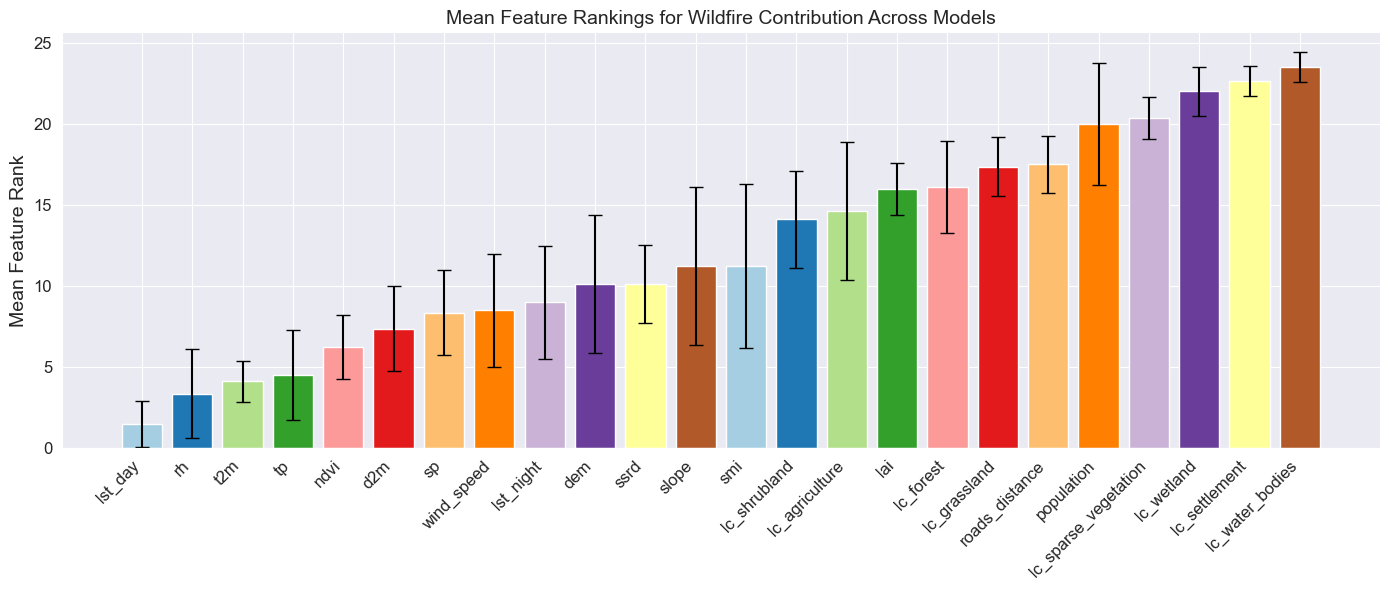

In [60]:
plot_feature_rank_barplot(df_ordered)

In [ ]:
for bar, rank in zip(bars, summary["MeanRank"]):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height - 2.5,
        f"{rank:.1f}",
        ha="center",
        va="bottom",
        fontsize=9,
        rotation=90,
        color="black"
    )